<a href="https://colab.research.google.com/github/drscook/REU_temp/blob/master/main_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Major improvement from v2 to v3 - More efficient handling of false collisions.  In v2, all walls reported ONE smallest positive time and we used the smallest of these.  If it resulted in a false collision, we simply didn't apply collision map or record state and move to the next step.  However, this re-computes all dt's again in next step.  This is wasteful.

In v3, all walls report ALL postitive times.  We try them from smallest to largest until we find one that gives a real collision.  This avoids re-computing dt's due to false collisions.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

tol = 1e-4

class Wall():
    def specular_law(self, part):
        n = self.get_normal(part)
        part.vel -= 2 * (n@part.vel) * n
        return part.vel
        
        
    def wrap_law(self, part):
        if wrap_wall_idx is None:
            raise Exception("Must specify wrap_wall to use wrap_law")
        part.wrap_count[self.wall_idx] += 1
        
        dx = self.base - part.pos
        s = x @ self.tangent        
        part.wall_idx = self.wrap_wall_idx
        new_base = Walls[self.wrap_wall_idx].base
        new_tangent = Walls[self.wrap_wall_idx].tangent
        part.pos = new_base + s * new_tangent
        
        
    def assign_law(self):
        if self.collision_law_name == "specular":
            self.resolve_collision = self.specular_law
        elif self.collision_law_name == "wrap":
            if self.wall_type != 'flat':
                raise Exception('Wrap only defined for flat walls')
            self.hard = False
            self.wrap_wall_idx = wrap_wall_idx
            self.resolve_collision = self.wrap_law

            
    def extend_ONB(self, A):
        A = np.asarray(A)
        if A.ndim == 0:
            return np.eye(self.dim)
        if A.ndim == 1:
            A = A[:,np.newaxis]
        m, n = A.shape
        if m <= n:
            A = A.T
            m, n = n, m
        F = np.linalg.qr(A, 'complete')[0].T
        s = np.sign(F@A)
        F[:n] *= np.diag(s).reshape(-1,1)
        return F

           
    def cap_endpoints(self, Walls):
        pts = self.draw_me().T
        normal = pts[0] - pts[1]
        new_wall = SphereWall(base=pts[0], radius=0.0, axes=[normal],
                              max_polar_angle=np.pi/2*1.01, outside=True, inside=False)
        Walls.append(new_wall)
        normal = pts[-1] - pts[-2]
        new_wall = SphereWall(base=pts[-1], radius=0.0, axes=[normal],
                              max_polar_angle=np.pi/2*1.01, outside=True, inside=False)
        Walls.append(new_wall)
        return Walls

        
class FlatWall(Wall):
    def __init__(self, base, length, axes=None, collision_law="specular", 
                 wrap_wall_idx=None, hard=True, two_sided=False):
        self.wall_type = 'flat'
        self.collision_law_name = collision_law
        self.base = np.array(base)
        self.dim = len(self.base)
        self.two_sided = two_sided
        self.hard = hard
        self.length = length
        self.total_arclength = 2 * self.length
        if self.two_sided:
            self.total_arclength *= 2
        
        self.axes = self.extend_ONB(axes)
        self.normal = self.axes[0]
        self.tangent = self.axes[1:]
        
        self.wrap_wall_idx = wrap_wall_idx
        self.assign_law()
           
            
    def get_normal(self, part):
        return self.normal
    
    
    def get_frame(self, part):
        return self.axes
    
    
    def get_dt(self, part):
        c1 = part.vel @ self.normal
        if abs(c1) < tol:
            self.dt = [np.inf]
        else:
            dx = self.base - part.pos
            dx_normal = dx @ self.normal
            T = []
            r = part.radius * self.hard
            for R in {r, -r}:
                c0 = dx_normal - R
                T.append(c0 / c1)
            if len(T) == 0:
                self.dt = [np.inf]
            else:
                self.dt = np.array(T)
                if self.wall_idx == part.wall_idx:
                    idx = np.argmin(np.abs(self.dt))
                    self.dt[idx] = np.inf
                idx = (self.dt < 0)
                self.dt[idx] = np.inf
        return self.dt

                
    def check_real_collision_get_arclength(self, part):
        if self.wall_idx < part.wall_idx:
            self.arclength = self.total_arclength
        elif self.wall_idx > part.wall_idx:
            self.arclength = 0
        else:
            dx = self.base - part.pos
            F = self.axes.T
            dx_frame = dx @ F
            if np.abs(dx_frame[1]) > self.length:
                self.arclength = -np.inf
            else:
                self.arclength = dx_frame[1] + self.length
                
            if self.two_sided and dx_frame[0] >= 0:
                self.arclength += self.total_arclength / 2
        return self.arclength
    
    
    def draw_me(self):
        try:
            return self.boundary
        except:
#             print(f"Computing boundary points for wall {self.wall_idx}")
            s = np.linspace(-self.length, self.length, 100)
            self.boundary = (self.base + self.tangent * s[:,np.newaxis]).T
            return self.boundary

                
class SphereWall(Wall):
    def __init__(self, base, radius, axes=None, max_polar_angle=np.pi,
                 collision_law="specular", wrap_wall_idx=None, hard=True,
                 inside=False, outside=True):
        self.wall_type = 'sphere'
        self.collision_law_name = collision_law
        self.base = np.array(base)
        self.dim = len(self.base)
        self.hard = hard
        self.radius = radius
        self.axes = self.extend_ONB(axes)
        assert 0 <= max_polar_angle <= np.pi, f"max_polar_angle must lie between 0 and pi; got {max_polar_angle}"
        self.max_polar_angle = max_polar_angle
        self.max_normal_projection = -np.cos(max_polar_angle)
        
        assert inside or outside, f"At least one of inside or outside must be True"
        self.inside = inside
        self.outside = outside
                
        self.inside_arclength = 2 * self.max_polar_angle * self.inside * (self.radius - part.radius * self.hard)
        self.outside_arclength = 2 * self.max_polar_angle * self.outside * (self.radius + part.radius * self.hard)
        self.total_arclength = self.inside_arclength + self.outside_arclength
        self.wrap_wall_idx = wrap_wall_idx
        self.assign_law()
    
    
    def get_normal(self, part):
        dx = self.base - part.pos
        return dx / np.linalg.norm(dx)
    
    
    def get_frame(self, part):
        n = self.get_normal(part)
        return self.extend_ONB(n)

    
    def get_dt(self, part):
        dx = self.base - part.pos
        dv = part.vel
        c2 = dv @ dv
        c1 = -2 * dx @ dv
        
        T = []
        r = part.radius * self.hard
        for R in {self.radius + r, self.radius - r}:
            if R < 0:
                continue
            c0 = dx @ dx - R**2
            if abs(c2) < tol:
                if abs(c1) > tol:
                    t = c0 / c1
                    T.append(t)
            else:
                d = c1**2 - 4 * c2 * c0
                if d >= 0:
                    s = np.sqrt(d)
                    T.append((-c1 + s) / (2 * c2))
                    T.append((-c1 - s) / (2 * c2))
        if len(T) == 0:
            self.dt = [np.inf]
        else:
            self.dt = np.array(T)
            if self.wall_idx == part.wall_idx:
                idx = np.argmin(np.abs(self.dt))
                self.dt[idx] = np.inf
            idx = (self.dt < 0)
            self.dt[idx] = np.inf
        return self.dt

    
    def check_real_collision_get_arclength(self, part):
        if self.wall_idx < part.wall_idx:
            self.arclength = self.total_arclength
        elif self.wall_idx > part.wall_idx:
            self.arclength = 0
        else:
            dx = self.base - part.pos
            mag = np.linalg.norm(dx)
            dx /= mag
            F = self.axes.T
            dx_frame = dx @ F
            if dx_frame[0] > self.max_normal_projection:
                self.arclength = -np.inf
            else:
                polar_angle = (np.pi - np.arccos(dx_frame[0])) * np.sign(dx_frame[1])
                if mag < self.radius:
                    self.arclength = (polar_angle + self.max_polar_angle) * (self.radius - part.radius * self.hard)
                else:
                    self.arclength = (polar_angle + self.max_polar_angle) * (self.radius + part.radius * self.hard)
                    self.arclength += self.inside_arclength
        return self.arclength
        

    def draw_me(self):
        try:
            return self.boundary
        except:
#             print(f"Computing boundary points for wall {self.wall_idx}")
            s = np.linspace(-self.max_polar_angle, self.max_polar_angle, 100)
            self.boundary = np.array([np.cos(s), np.sin(s)]) * self.radius
            self.boundary = self.axes.T @ self.boundary
            self.boundary += self.base[:,np.newaxis]
            return self.boundary
                
            
class Particle():
    def __init__(self, dim=2, radius=1, mass=1, gamma=1/np.sqrt(2)):
        self.dim = dim
        self.radius = radius
        self.mass = mass
        self.gamma = gamma
        self.inertia = self.mass * self.gamma * self.radius**2


    def draw_me(self):
        try:
            return self.boundary
        except:
#             print(f"Computing boundary points for particle")
            s = np.linspace(-np.pi, np.pi, 100)
            self.boundary = self.radius * np.array([np.cos(s), np.sin(s)])
            return self.boundary


    def check_real_collision_get_arclength(self):
        arclengths = [wall.check_real_collision_get_arclength(self) for wall in Walls]
        self.arclength = np.sum(arclengths)
        if self.arclength >= 0:
            self.real_collision = True
        else:
            self.real_collision = False
            self.arclength = np.nan
        return self.real_collision

    
    def get_phi(self):
        F = Walls[self.wall_idx].get_frame(self).T
        dv = part.vel / np.linalg.norm(part.vel)
        dv_frame = dv @ F
        self.phi = np.arccos(abs(dv_frame[0])) * np.sign(dv_frame[1])
        return self.phi


    
def initialize(part, Walls):
    for i in range(len(Walls)):
        Walls[i].wall_idx = i
   
    start_wall = Walls[0]
    part.wall_idx = start_wall.wall_idx

    # particle's initial position will be against the scatterer at angle theta to the positive x-axis
    theta = np.random.rand() * np.pi / 4  
    part.pos = np.array([np.cos(theta), np.sin(theta)]) * (part.radius + start_wall.radius)


    # particle's initial velocity will be at angle phi to the normal vector at intial position
    a = np.random.rand()  # between 0 and 1
    a = 2*a - 1  # between -1 and +1
#     phi =  a * np.pi / 2  #between -pi/2 and +pi/2
    phi =  np.arcsin(a)  # Follows the cosine law, the invariant measure for the billiard map


    # Now, we need to get a normal vector to the scatterer at intitial position.
    n = -1*start_wall.get_normal(part)


    # Now, we want to rotate it by angle phi.  So, create the rotation matrix.
    R = np.array([[np.cos(phi), -np.sin(phi)],
                  [np.sin(phi), np.cos(phi)]
                 ])

    # Apply it to n
    part.vel = R@n
    
    part.t = 0
    part.check_real_collision_get_arclength()
    part.get_phi()
    part.wrap_count = np.zeros(len(Walls), int)
    return part, Walls

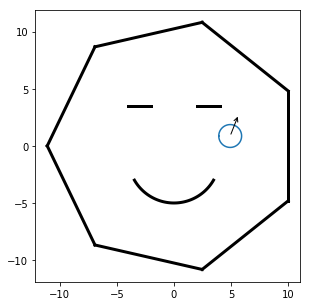

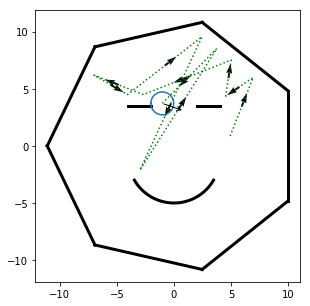

In [10]:
np.random.seed(5)  # produces the same thing every thing - easier for debugging

steps = 10
dim = 2

part = Particle(radius=1.0)

Walls = []
polygon_sides = 7
polygon_radius_inscribed = 10

scatterer_radius = 4
assert (scatterer_radius < polygon_radius_inscribed), "scatterer won't fit in the polygon"  # checks that the scatterer fits
new_wall = SphereWall(base=[0.0, -1.0], radius=scatterer_radius, max_polar_angle = np.pi/3,
                      axes=[[0,-1],[1,0]], hard=True, inside=True, outside=True)
Walls.append(new_wall)
if new_wall.max_polar_angle < np.pi:
    new_wall.cap_endpoints(Walls)


length = np.tan(np.pi / polygon_sides) * polygon_radius_inscribed
for i, theta in enumerate(np.linspace(0, 2*np.pi, polygon_sides, endpoint=False)):
    v = np.array([np.cos(theta), np.sin(theta)])
    b = v * polygon_radius_inscribed
    n = -1 * v
    t = [n[1], -n[0]]
    axes = [n, t]
    new_wall = FlatWall(base=b, axes=axes, length=length)
    Walls.append(new_wall)

new_wall = FlatWall(base=[-3.0,3.5], axes=[0,1], length=1, two_sided=True)#, hard=False)
Walls.append(new_wall)
new_wall.cap_endpoints(Walls)

new_wall = FlatWall(base=[3.0,3.51], axes=[0,1], length=1, two_sided=True)#, hard=False)
Walls.append(new_wall)
new_wall.cap_endpoints(Walls)


part, Walls = initialize(part, Walls)
# part.pos = np.array([3,1.98])
# part.vel = np.array([1.0,0.0])

%run -i dynamics

state_history = record_state(part)  # creates state_history because we didn't pass in state_history
ax = draw(state_history, Walls)
plt.show()


for i in range(steps):
#     print(f"step {i}")
    
    part, Walls = next_state(part, Walls)  # evolves the system forward one step

    if part.real_collision:
        ## record current state for later use
        state_history = record_state(part, state_history)  # record in the existing state_history
    else:
        print(f"skipping step {i}")
ax = draw(state_history, Walls)
plt.show()

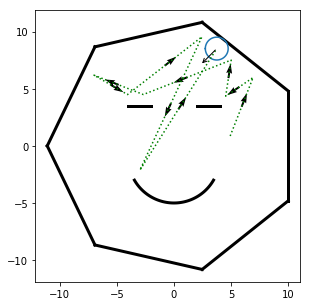

In [11]:
#@title Interactive {run: "auto"}
plot_steps =9 #@param {type:"slider", min:0, max:50, step:1}

ax = draw(state_history, Walls, stop_step=plot_steps+1)
# ax = draw(runs[1], steps=plot_steps, ax=ax)
plt.show()

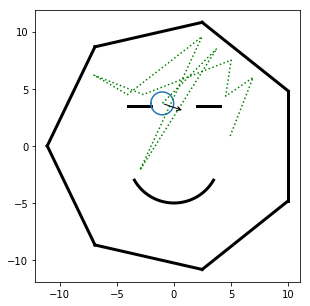

In [49]:
from copy import deepcopy

def animate(state_history, movie_time=10, frame_rate=60):
    pos = np.asarray(state_history['POS'])
    vel = np.asarray(state_history['VEL'])
    t   = np.asarray(state_history['T'])
    
    frame_count = movie_time * frame_rate
    
    dist = np.linalg.norm(pos, axis=-1)
    cum_dist = np.cumsum(dist)
    
    max_flight = np.linalg.norm(np.ptp(pos, axis=0))
    max_flight_frame = max_flight / 10
    max_cum_dist = max_flight_frame * frame_count
    idx = cum_dist < max_cum_dist
    
    pos = pos[idx]
    vel = vel[idx]
    t   = t[idx] - t[0]
    
    dt_frame_ave = t[-1] / frame_count
    dt_collision = np.diff(t)
    frames_interp = np.ceil(dt_collision / dt_frame_ave).astype(int)
    
    dt = np.append(dt_collision / frames_interp, 0)

    def interp(x):
        x_interp = np.repeat(x[:-1], frames_interp, axis=0)    
        x_interp = np.append(x_interp, x[[-1]], axis=0)
        return x_interp
    
    state_history_interp = deepcopy(state_history)
    state_history_interp['DT'] = np.hstack([dt * np.arange(f) for dt, f in zip(dt, frames_interp)]+[0])
    state_history_interp['VEL'] = interp(vel)
    state_history_interp['T']   = interp(t)
    state_history_interp['POS'] = interp(pos)
    state_history_interp['POS']+= state_history_interp['VEL'] * state_history_interp['DT'][:,np.newaxis]
    
    return state_history_interp

state_history_interp = animate(state_history, movie_time=1)

draw(state_history_interp, Walls, arrows=False)

In [47]:
print(state_history['POS'][-1])
print(state_history_interp['POS'][-1])

[-1.02558089  3.72473849]
[-1.02558089  3.72473849]


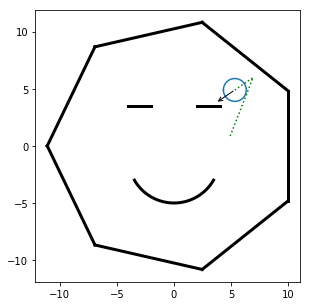

In [44]:
#@title Interactive {run: "auto"}
plot_steps =7 #@param {type:"slider", min:0, max:50, step:1}

ax = draw(state_history_interp, Walls, stop_step=plot_steps+1, arrows=False)
# ax = draw(runs[1], steps=plot_steps, ax=ax)
plt.show()

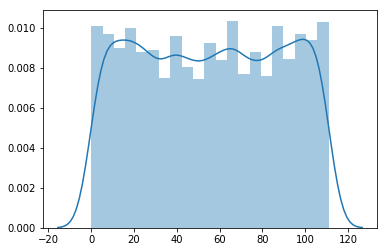

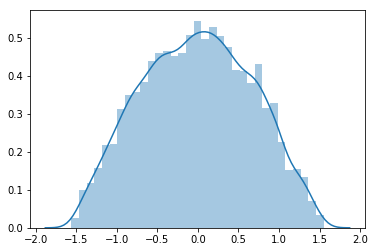

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(np.nan_to_num(state_history['ARCLENGTH']))
plt.show()
sns.distplot(state_history['PHI'])
plt.show()

In [0]:
A = [w.total_arclength for w in Walls]

In [0]:
print(A)
np.cumsum(A)

[10.471975511965976, 6.283185307179586, 6.283185307179586, 9.631492376150572, 9.631492376150572, 9.631492376150572, 9.631492376150572, 9.631492376150572, 9.631492376150572, 9.631492376150572, 2, 6.283185307179586, 6.283185307179586, 2, 6.283185307179586, 6.283185307179586]


array([ 10.47197551,  16.75516082,  23.03834613,  32.6698385 ,
        42.30133088,  51.93282325,  61.56431563,  71.19580801,
        80.82730038,  90.45879276,  92.45879276,  98.74197807,
       105.02516337, 107.02516337, 113.30834868, 119.59153399])

In [0]:
L = [1,2,3]
d = 5-len(L)
L += [np.inf]*d
L

[1, 2, 3, inf, inf]